In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

!unzip \*.zip && rm*.zip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

train_path='/content/train'
test_path='/content/test'
val_path='/content/val'

batch_size =16

img_height=64
img_width=64


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )# Create Image Data Generator for Test/Validation Set

# For the testset we are just going for rescale in order to avoid manipulating the testset before hand
test_data_gen = ImageDataGenerator(rescale = 1./255)

from sklearn.svm import SVC
import numpy as np


### Densenet expects the input image to be in rbf format.
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      val_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='binary',
      batch_size=batch_size
      )
# Since the images are x ray images hence we will be loading them as grey scale

Streaming output truncated to the last 5000 lines.
  inflating: train/normal/IM-0437-0001.jpeg  
  inflating: train/normal/IM-0438-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0002.jpeg  
  inflating: train/normal/IM-0439-0001.jpeg  
  inflating: train/normal/IM-0440-0001.jpeg  
  inflating: train/normal/IM-0441-0001.jpeg  
  inflating: train/normal/IM-0442-0001.jpeg  
  inflating: train/normal/IM-0444-0001.jpeg  
  inflating: train/normal/IM-0445-0001.jpeg  
  inflating: train/normal/IM-0446-0001.jpeg  
  inflating: train/normal/IM-0447-0001.jpeg  
  inflating: train/normal/IM-0448-0001.jpeg  
  inflating: train/normal/IM-0449-0001.jpeg  
  inflating: train/normal/IM-0450-0001.jpeg  
  inflating: train/normal/IM-0451-0001.jpeg  
  inflating: train/normal/IM-0452-0001.jpeg  
  inflating: train/normal/IM-0453-0001-0002.jpeg  
  inflating: train/normal/IM-0453-0001.jpeg  
  inflating: train/normal/IM-0455-0001.jpeg  
  inflating: t

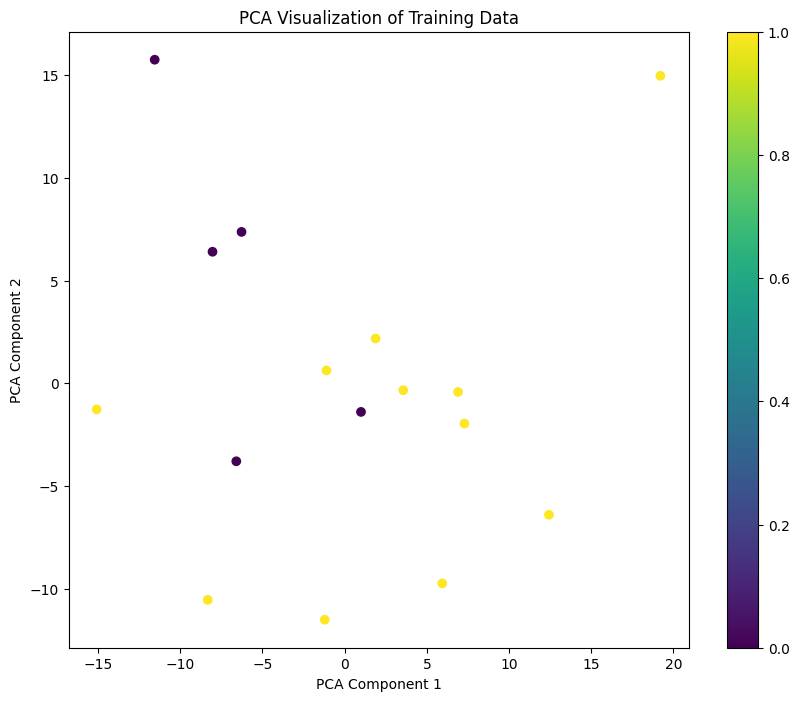

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get image data from the ImageDataGenerator
X_train, y_train = next(train)

# Reshape image data to 1D array
X_train_flatten = X_train.reshape(X_train.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_flatten)

# Plot PCA visualization
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('PCA Visualization of Training Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get image data from the ImageDataGenerator
X_train, y_train = next(train)

# Reshape image data to 1D array
X_train_flatten = X_train.reshape(X_train.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_flatten)

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Training Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


ValueError: perplexity must be less than n_samples

In [ ]:
image_paths = []
for root, _, files in os.walk(train_path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_paths.append(os.path.join(root, file))


In [ ]:
histograms = [extract_color_histogram(image_path) for image_path in image_paths]

In [ ]:
histograms = np.array(histograms)

In [ ]:
print(histograms.shape)

(0,)


In [ ]:
from keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
from keras.applications.resnet50 import preprocess_input
def extract_features(data_generator, sample_count):
    features = np.zeros(shape=(sample_count, 2, 2, 2048))  # Shape of features extracted by ResNet50
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in data_generator:
        features_batch = base_model.predict(preprocess_input(inputs_batch))
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


In [ ]:
train_features, train_labels = extract_features(train,4192)

1/1 [==============================] - 0s 251ms/step


In [ ]:
train_features = np.reshape(train_features, (4192, 2 * 2 * 2048))

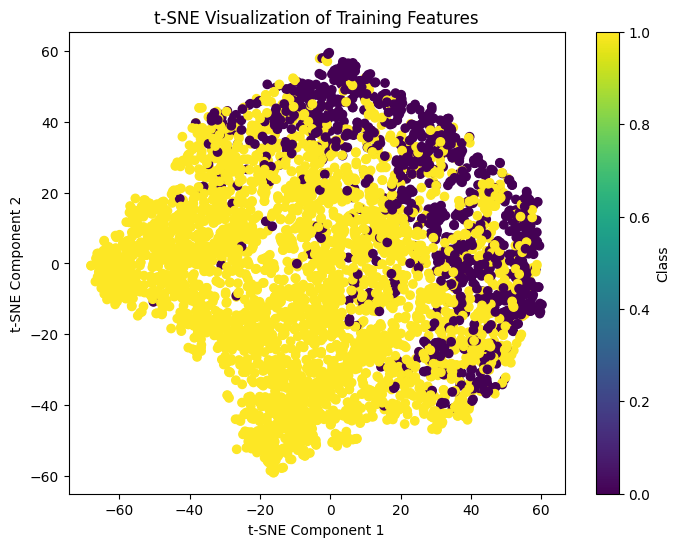

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)

# Plot the t-SNE embeddings
plt.figure(figsize=(8, 6))
plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_labels, cmap='viridis')
plt.title('t-SNE Visualization of Training Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Class')
plt.show()

In [ ]:
validation_features, validation_labels = extract_features(valid, 1040)
validation_features = np.reshape(validation_features, (1040, 2 * 2 * 2048))

1/1 [==============================] - 0s 242ms/step


In [ ]:
test_features, test_labels = extract_features(valid,  624)
test_features = np.reshape(test_features, ( 624, 2 * 2 * 2048))

1/1 [==============================] - 0s 253ms/step


In [ ]:
svm_classifier_rbf = SVC(kernel='linear')
svm_classifier_rbf.fit(train_features, train_labels)
accuracy = svm_classifier_rbf.score(validation_features, validation_labels)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9375


In [ ]:
accuracy = svm_classifier_rbf.score(test_features,  test_labels)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9375


In [ ]:
from sklearn.metrics import classification_report
predictions = svm_classifier_rbf.predict(test_features)
report = classification_report(y_true=test_labels, y_pred=predictions, target_names=['NORMAL', 'PNEUMONIA'])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.86      0.91      0.88       160
   PNEUMONIA       0.97      0.95      0.96       464

    accuracy                           0.94       624
   macro avg       0.91      0.93      0.92       624
weighted avg       0.94      0.94      0.94       624

